# results

In [1]:
import pandas as pd
import glob
import numpy as np
import os
from collections import OrderedDict 
import json
import scipy.io
import sklearn.metrics
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib
import matplotlib.ticker as ticker

from PIL import Image
%matplotlib inline

from joblib import Parallel, delayed
from time import time

import seaborn as sns
import seaborn as sns
sns.set(font_scale=1.5)
# sns.set_style("ticks")
sns.set_style("ticks", {
    "ytick.major.size": 0.1,
    "ytick.minor.size": 0.05,
    'grid.linestyle': '--'
 })
from adjustText import adjust_text
# current_palette = sns.color_palette()
# sns.palplot(current_palette)

import re

import collections

import sklearn.metrics

import copy

from tqdm import tqdm,tnrange,tqdm_notebook

import collections

#my own imports
import sys
if "../code/" not in sys.path:
    sys.path.append("../code/")

def parse_results(glob_path,no_log=True):
    print("parsing",glob_path)
    table = []
    for path_ori in glob.glob(glob_path):
        #history = json.load(open(path))
        exp_dir = os.path.split(path_ori)[0]
        
        opt = {}
        path = os.path.join(exp_dir,"args.json")
        if os.path.exists(path):
            try:
                opt = json.load(open(path))
            except:
                print(path)
        else:
            print("not found:",path)
            continue
            
        opt["exp"] = path_ori
        log = json.load(open(path_ori))

        acc = -1
        if "test" in log:
            acc = log["test"]['acc']
        else:
            continue
        opt["acc"] = acc
        
        opt["iters"] = len(log["train"])
        try:
            opt["best_acc"] = log['best_acc']
            opt["best_epoch"] = log['best_epoch']
        except KeyError:
            pass
        opt["time_elapsed"] = log['time_elapsed']
        opt["log"] = log
        table.append(opt)
    df_results = pd.DataFrame(table)
    return df_results[sorted(df_results.columns)]

def organize_df(df):
    cols = list(df.columns)
    cols.remove("log")

    if "noun_pretraining_epochs" in df.columns:
        #because this is confusing. there's a case without pretraining even if noun_pretraining_epochs is non-zero
        df["noun_pretraining_epochs"] = df["noun_pretraining_epochs"]*(df["noun"]=='separate-twostep')
    
    noun_cols = [c for c in cols if c.startswith("noun")]
    other_cols =  [c for c in cols if not  c.startswith("noun")]
    
    cols = other_cols[0:2] + noun_cols + other_cols[2:] 
    
    df = df[cols].round(4).sort_values(["acc"])
    
    return df

def organize_df_add_training_data(df_results_all):
    df_results_all_new = []
    for i,row in df_results_all.iterrows():
        pkl_path = row['train'].replace("train.csv","setup.pkl").replace("_samplingseed-123","")
        name = os.path.basename(pkl_path).split("_seed")[0]
        setup = load_pkl(pkl_path)
        assert setup['configs']["N"] == len(pd.read_csv(row['train']))
        if "num_unique_nouns" not in setup['configs']:
            setup['configs']["num_unique_nouns"] = 0
        row = dict(row)
        row.update(setup)
        row.update(setup['configs'])
        num_unique_nouns = setup['configs']["num_unique_nouns"]
        num_common_nouns = setup['configs']["num_common_nouns"]
        row['name'] = name.split("_")[0] + "_NumCommonNouns-%d_NumUniqueNouns-%d"%(num_common_nouns,num_unique_nouns)
        df_results_all_new.append(row)
    df_results_all_new = pd.DataFrame(df_results_all_new).sort_values(["name"])
    return df_results_all_new

def postprocess_test_for_exp(row):
    all_ids = row["log"]['test']['all_ids']
    all_labels = row["log"]['test']['all_labels']
    all_outputs = row["log"]['test']['all_outputs']

    #df_train = pd.read_csv(row['train'], sep=',').set_index("narration_id")
    df_test = pd.read_csv(row['test'], sep=',').set_index("id").loc[all_ids]

    df_test["label"] = all_labels
    df_test["output"] = all_outputs

    label2name = {}
    temp = df_test.groupby(["label","verb_class_name"]).size().reset_index()
    for i,v in temp.iterrows():
        label2name[v['label']] = v['verb_class_name']
    assert len(temp) == len(df_test["verb_class_name"].unique())


    all_preds = np.array(all_outputs).argmax(axis=1)
    all_preds = [label2name[i] for i in all_preds]
    df_test["prediced_verb_class_name"] = all_preds

    df_test_type = row['df_test_type']
    test_types = pd.DataFrame(df_test_type.stack())
    df_test['test_type'] = df_test.apply(lambda x: test_types.loc[x["verb_class_name"],x["noun_class_name"]][0], axis=1)
    df_test["correctness"] = df_test["verb_class_name"] == df_test["prediced_verb_class_name"]
    return df_test


def compute_test_accs(df_results_all):
    def process(row):
        row = row.copy()
        df_test = postprocess_test_for_exp(row)
        df_test.groupby(["test_type"])["correctness"].mean()
        test_accs = dict(df_test.groupby(["test_type"])["correctness"].mean())
        for k,v in test_accs.items():
            row[k] = v
        row["df_test"] = df_test
        return row
    
    df_results_all_new = Parallel(n_jobs=-1,verbose=10)( [delayed(process)(row) for i,row in df_results_all.iterrows()] )
    df_results_all_new = pd.DataFrame(df_results_all_new)
    return df_results_all_new

# def compute_test_accs(df_results_all):
#     df_results_all_new = []
#     for i,row in tqdm(df_results_all.iterrows()):
#         df_test = postprocess_test_for_exp(row)
#         df_test.groupby(["test_type"])["correctness"].mean()
#         test_accs = dict(df_test.groupby(["test_type"])["correctness"].mean())
#         for k,v in test_accs.items():
#             row[k] = v
#         df_results_all_new.append(row)
#         row["df_test"] = df_test
#     df_results_all_new = pd.DataFrame(df_results_all_new)
#     return df_results_all_new
    
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14,title=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize,dpi=100)
    heatmap = sns.heatmap(df_cm, annot=True,fmt='.2f',annot_kws={"size": fontsize},xticklabels=class_names,yticklabels=class_names)
    #heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    #heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title is not None:
        plt.title(title)
    return fig

import pickle
def save_pkl(path,obj):
    with open(path, 'wb') as f:
        pickle.dump(obj,f)
        
def load_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def make_dir_if_needed(path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
value_to_int = {'testing_common_obj': 0,
            'testing_unseen_obj': 1,
             'testing_unqiue-self_obj': 2,
             'testing_unique-other_obj': 3,
             }
hue_order = ['testing_common_obj', 'testing_unseen_obj', 'testing_unqiue-self_obj', 'testing_unique-other_obj']
test_name_map = [('testing_common_obj',"common"),('testing_unseen_obj', "unseen"), ('testing_unqiue-self_obj',"unique-self"),('testing_unique-other_obj',"unique-other")] 
test_name_map = OrderedDict(test_name_map)

In [2]:
selected_verbs = ['Picking [something] up', 'Putting [something]', 'Dropping [something]', 'Moving [something] from left to right', 'Moving [something] from right to left']
selected_nouns = ['pencil', 'bottle', 'pen', 'book', 'box', 'remote', 'key', 'wallet', 'phone', 'marker', 'paper', 'charger', 'knife', 'battery', 'mouse', 'cup', 'watch', 'brush', 'glasses', 'scissors', 'comb', 'spoon', 'lighter', 'toy', 'tissue', 'shoe', 'screwdriver', 'stapler', 'glass', 'calculator']
common_nouns = selected_nouns[0:10]
unique_nouns = selected_nouns[10:20]
unseen_nouns = selected_nouns[20:30]

In [135]:
#save_pkl("./results/cvpr-rerun-renset18-rgb-flow.pkl",df_results_all)

In [3]:
glob_path = "./experiments/*/*/*/cvpr-v4-something/*/log.json"
df_results_all = parse_results(glob_path).query("loss_balanced==1")
df_results_all = organize_df_add_training_data(df_results_all)
df_results_all = compute_test_accs(df_results_all)
df_results_all["loss_balanced"] = df_results_all["loss_balanced"].fillna(0)

df_results_all["num_common_nouns"] = df_results_all["num_common_nouns"].astype(int)
df_results_all["num_unique_nouns"] = df_results_all["num_unique_nouns"].astype(int)
df_results_all['input'] = df_results_all['input'].apply(lambda x:".".join(x))
df_acc_summary = df_results_all[["exp","input","N","loss_balanced","name","num_common_nouns",'num_unique_nouns']+list(value_to_int.keys())]
#save_pkl("./results/cvpr-rerun-renset18-rgb-flow.pkl",df_results_all)

parsing ./experiments/*/*/*/cvpr-v4-something/*/log.json


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:  

In [4]:
def format_for_seaborn(df_temp,flatten=False):
    if flatten:
        df_temp_all = []
        for i,row in df_temp.iterrows():
            df_temp_test = row["df_test"].copy()
            df_temp_test["num_unique_nouns"] = row["num_unique_nouns"]
            df_temp_test["num_common_nouns"] = row["num_common_nouns"]
            df_temp_test["N"] = row["N"]
            df_temp_test["label"] = str(row["num_common_nouns"]) + "c.+" + str(row["num_unique_nouns"]) + "u."
            df_temp_all.append(df_temp_test)
        df_temp_all = pd.concat(df_temp_all).reset_index()
        return df_temp_all
    else:
        df_temp =  df_temp[["N","num_common_nouns",'num_unique_nouns']+list(value_to_int.keys())]
        df_temp = pd.DataFrame(df_temp[["N","num_common_nouns","num_unique_nouns"]+ list(value_to_int.keys())]\
                 .set_index(["N","num_common_nouns","num_unique_nouns"]).stack()).reset_index().rename(columns={0:'acc',"level_3":"test_type"})
        df_temp["label"] =  df_temp["num_common_nouns"].astype(str) + "c.+" + df_temp["num_unique_nouns"].astype(str) + "u."
        df_temp["correctness"] = df_temp["acc"]
        return df_temp

In [6]:
df_results_all_flattend =  format_for_seaborn(df_results_all,flatten=True)
df_acc_summary = pd.DataFrame(df_results_all_flattend.query("num_common_nouns<=6")\
                              .groupby(["N","num_common_nouns","num_unique_nouns","test_type"]).mean()["correctness"]).rename({"correctness":"acc"}, axis='columns')
df_acc_summary = df_acc_summary.reset_index()
df_acc_summary.to_excel("./results/something-acc-summary-rerun.xlsx")

# For paper

rgb 375


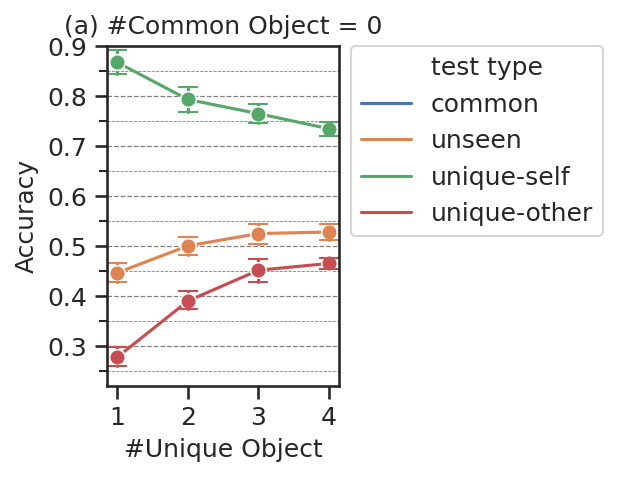

In [14]:
N = 375
input = "rgb"
loss_balanced = 1
fontsize = 12

print(input,N)
df_results_all_temp = df_results_all.query("input=='%s'"%input).query("loss_balanced==%d and N==%d"%(loss_balanced,N))

if len(df_results_all_temp)==0:
    assert False
df_results_all_temp = df_results_all_temp.query("num_common_nouns==0")

df_temp = format_for_seaborn(df_results_all_temp,flatten=False)
df_temp["test type"] = df_temp["test_type"].map(test_name_map)

cmap = sns.color_palette(n_colors=4)
plt.figure(dpi=150,figsize=(2,3))


ax = sns.lineplot(x="num_unique_nouns", y="correctness", hue="test type", data=df_temp ,ci=95,err_style="bars", 
                  marker=".",markersize=15,hue_order = test_name_map.values(),palette = cmap,err_kws={'capsize':5})

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.6', color='black', alpha = 0.5)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.yaxis.grid(which='minor', linestyle='--', linewidth='0.4', color='black', alpha = 0.5)

ax.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,fontsize=fontsize)

ax.set_title("(a) #Common Object = 0")
ax.set_xlabel("#Unique Object")
ax.set_ylabel("Accuracy")
plt.xticks(range(1,5),rotation=0)
ax.set_ylim(0.22,0.9)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fontsize)
name = "exp-unique-only"
if input=="flow":
    print("----")
    print("flow")
    name+="flow"
plt.savefig("../results/"+name+".pdf",dpi=200, bbox_inches='tight', pad_inches = 0)
plt.show()
plt.close()

rgb 375


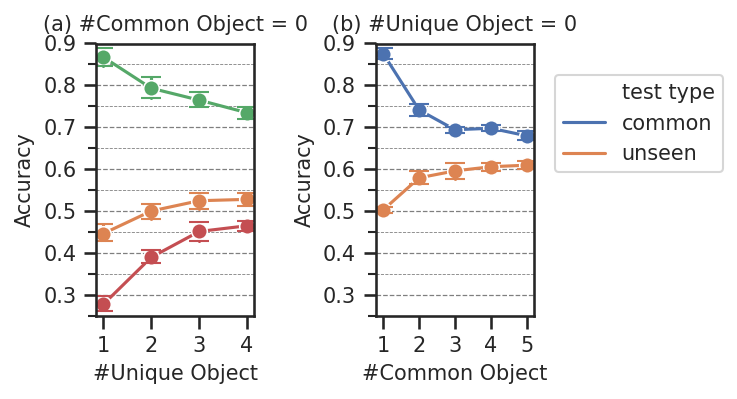

In [15]:
N = 375
input = "rgb"
loss_balanced = 1
fontsize = 10

fig, axs = plt.subplots(1, 2,figsize=(4, 3),dpi=150,)
print(input,N)
df_results_all_temp = df_results_all.query("input=='%s'"%input).query("loss_balanced==%d and N==%d"%(loss_balanced,N))

if len(df_results_all_temp)==0:
    assert False
df_results_all_temp = df_results_all_temp.query("num_common_nouns==0")

df_temp = format_for_seaborn(df_results_all_temp,flatten=False)
df_temp["test type"] = df_temp["test_type"].map(test_name_map)

ax = axs[0]
cmap = sns.color_palette(n_colors=4)
ax = sns.lineplot(x="num_unique_nouns", y="correctness", hue="test type", data=df_temp ,ci=95,err_style="bars", 
                  marker=".",markersize=15,hue_order = test_name_map.values(),palette = cmap,err_kws={'capsize':5},ax=ax)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.6', color='black', alpha = 0.5)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.yaxis.grid(which='minor', linestyle='--', linewidth='0.4', color='black', alpha = 0.5)

ax.get_legend().remove()

ax.set_title("(a) #Common Object = 0")
ax.set_xlabel("#Unique Object")
ax.set_ylabel("Accuracy")
ax.set_xticks(range(1,5))
ax.set_ylim(0.25,0.9)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fontsize)
name = "exp-unique-only"
if input=="flow":
    print("----")
    print("flow")
    name+="flow"
#plt.savefig("../results/"+name+".pdf",dpi=200, bbox_inches='tight', pad_inches = 0)


loss_balanced = 1
df_results_all_temp = df_results_all.query("input=='%s'"%input).query("loss_balanced==%d and N==%d"%(loss_balanced,N))
df_results_all_temp = df_results_all_temp.query("num_unique_nouns==0 and num_common_nouns<6")
if len(df_results_all_temp)==0:
    assert False
df_temp = format_for_seaborn(df_results_all_temp,flatten=False)
df_temp["test type"] = df_temp["test_type"].map(test_name_map)

cmap = sns.color_palette(n_colors=2)
ax = axs[1]
ax = sns.lineplot(x="num_common_nouns", y="correctness", hue="test type", data=df_temp ,ci=95,err_style="bars", 
                  marker=".",markersize=15,hue_order = list(test_name_map.values())[0:2],palette = cmap,err_kws={'capsize':5},ax=ax)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.6', color='black', alpha = 0.5)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.yaxis.grid(which='minor', linestyle='--', linewidth='0.4', color='black', alpha = 0.5)

ax.get_legend().remove()

ax.set_title("(b) #Unique Object = 0")
ax.set_ylim(0.25,0.9)
ax.set_xlabel("#Common Object")
ax.set_ylabel("Accuracy")
plt.xticks(range(1,6),rotation=0)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fontsize)
if input=="flow":
    name+="flow"

name = "uniqe-common"
plt.tight_layout()
# handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,ncol=1,fontsize=fontsize,bbox_to_anchor=(0.95,0.8), loc='upper left')
plt.savefig("../results/"+name+".pdf",dpi=200, bbox_inches='tight', pad_inches = 0)
plt.show()
plt.close()

rgb


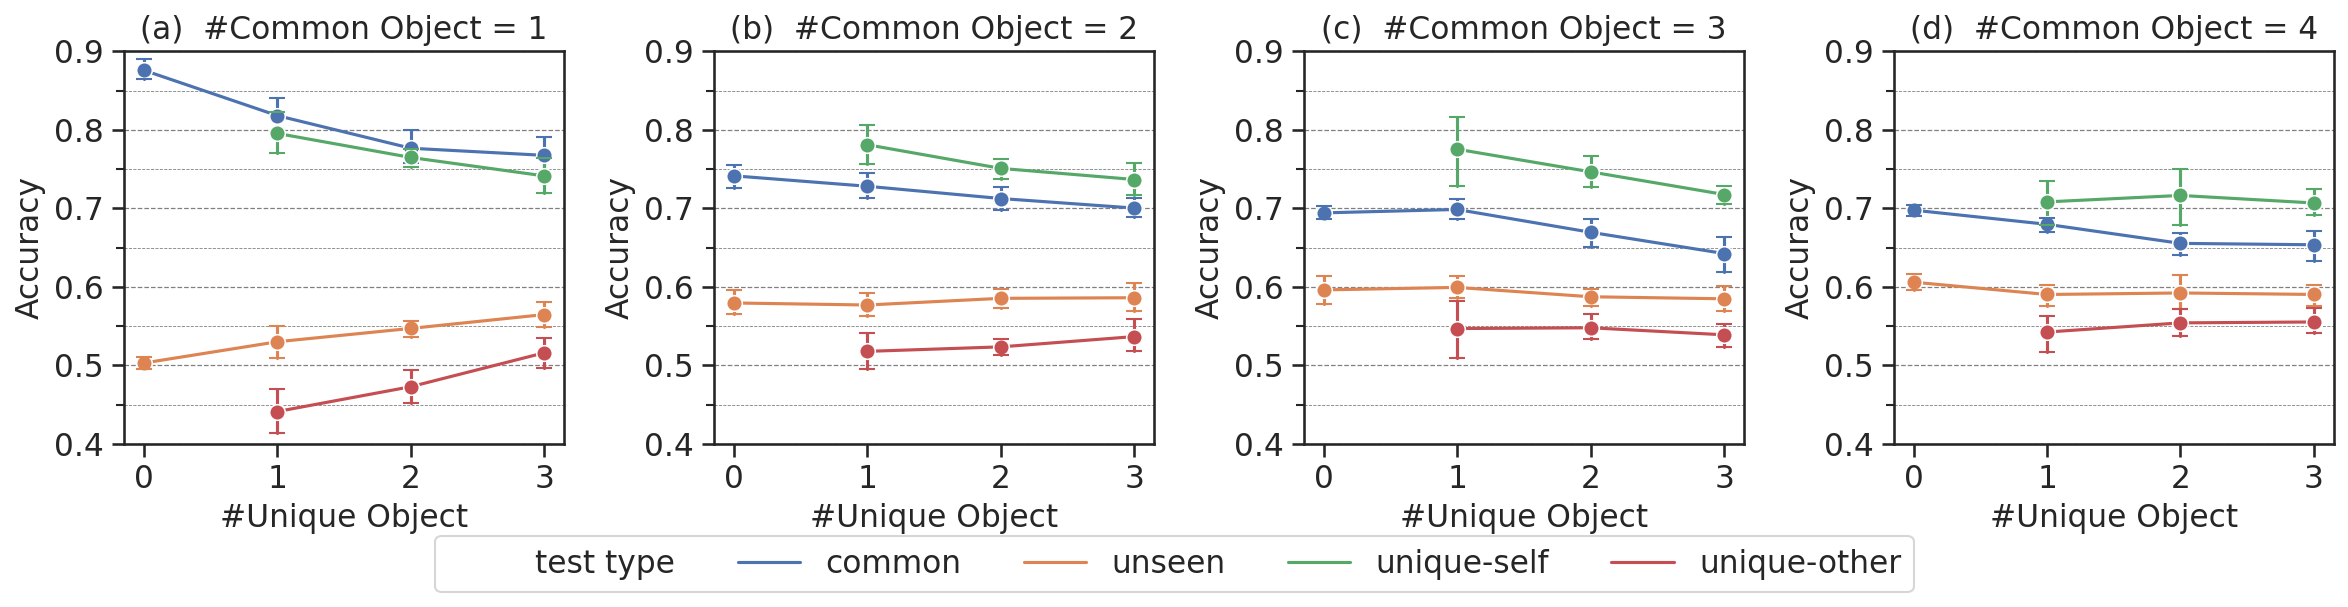

In [21]:
N = 375
input = "rgb"
loss_balanced = 1
fontsize = 15
print(input)
fig, axs = plt.subplots(1, 4,figsize=(4*4, 4),dpi=150,)

for i in range(1,5):
    df_results_all_temp = df_results_all.query("input=='%s'"%input).query("loss_balanced==%d and N==%d"%(loss_balanced,N))
    df_results_all_temp = df_results_all_temp.query("num_common_nouns==%d and num_unique_nouns<4"%i)
    if len(df_results_all_temp)==0:
        break
    df_temp = format_for_seaborn(df_results_all_temp,flatten=False)
    df_temp["test type"] = df_temp["test_type"].map(test_name_map)

    cmap = sns.color_palette(n_colors=4)

    ax = axs[i-1]
    ax = sns.lineplot(x="num_unique_nouns", y="correctness", hue="test type", data=df_temp ,ci=95,err_style="bars",
                      marker=".",markersize=15,hue_order = test_name_map.values(),palette = cmap,err_kws={'capsize':4},ax=ax)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.grid(which='major', linestyle='--', linewidth='0.6', color='black', alpha = 0.5)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth='0.4', color='black', alpha = 0.5)


    legend = ax.get_legend()
    legend.remove()

    ax.set_ylim(0.4,0.9)
    if input=="flow":
        ax.set_ylim(0.5,1)
    ax.set_xlabel("#Unique Object")
    ax.set_ylabel("Accuracy")
    ax.set_title("(%s)  #Common Object = %d"%(["a","b","c","d"][i-1],i))  

    plt.xticks([0,1,2,3],rotation=0)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

#     name = "exp-unique-only"
#     plt.savefig("../results/"+name+".pdf",dpi=200, bbox_inches='tight', pad_inches = 0)
# fig.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,fontsize=fontsize)
plt.tight_layout()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, 0.09),ncol=5,fontsize=fontsize)

name = "exp-common-unique"
if input=="flow":
    name+="flow"
plt.savefig("./results/"+name+".pdf",dpi=200, bbox_inches='tight', pad_inches = 0)

plt.show()
plt.close()

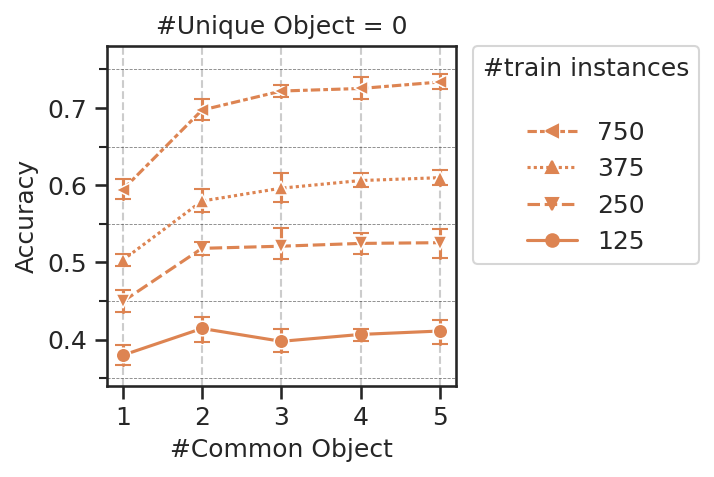

In [17]:
fontsize = 12
loss_balanced = 1
input = "rgb"
hue_order = None
plt.figure(dpi=150,figsize=(3,3))
value_to_int_verb = copy.deepcopy(value_to_int)
verb_selection = None
if verb_selection is not None:
    value_to_int_verb = {}
    for k,v in value_to_int.items():
        value_to_int_verb[verb_selection+"."+k] = v

df_temp = df_results_all.query("input=='%s'"%input).query("loss_balanced==%d and num_unique_nouns==0 and num_common_nouns<=5"%(loss_balanced))
df_temp_all = format_for_seaborn(df_temp,flatten=False).query("test_type=='testing_unseen_obj'")

# cmap = sns.color_palette(n_colors=len(df_temp["N"].unique()))
cmap = [sns.color_palette(n_colors=2)[1]]*len(df_temp["N"].unique())
ax = sns.lineplot(x="num_common_nouns", y="correctness", hue="N", data=df_temp_all ,ci=95,err_style="bars",
                  markers=["o","v","^","<",">"],markersize=7,hue_order=hue_order,palette = cmap,style="N",err_kws={'capsize':4})


ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.6', color='black', alpha = 0.5)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.yaxis.grid(which='minor', linestyle='--', linewidth='0.4', color='black', alpha = 0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:][::-1], labels[1:][::-1],ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,fontsize=fontsize)

ax.get_legend().set_title("#train instances\n")
ax.set_xlabel("#Common Object")
ax.set_ylabel("Accuracy")
ax.set_title("#Unique Object = 0")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fontsize)
ax.set_xticks(range(1,6))
ax.xaxis.grid();ax.yaxis.grid()
ax.set_ylim(0.34,0.78)
# ax.set_ylim(0,1)
name = "exp-num"
plt.savefig("../results/"+name+".pdf",dpi=200, bbox_inches='tight', pad_inches = 0)
plt.show()

# For internal use

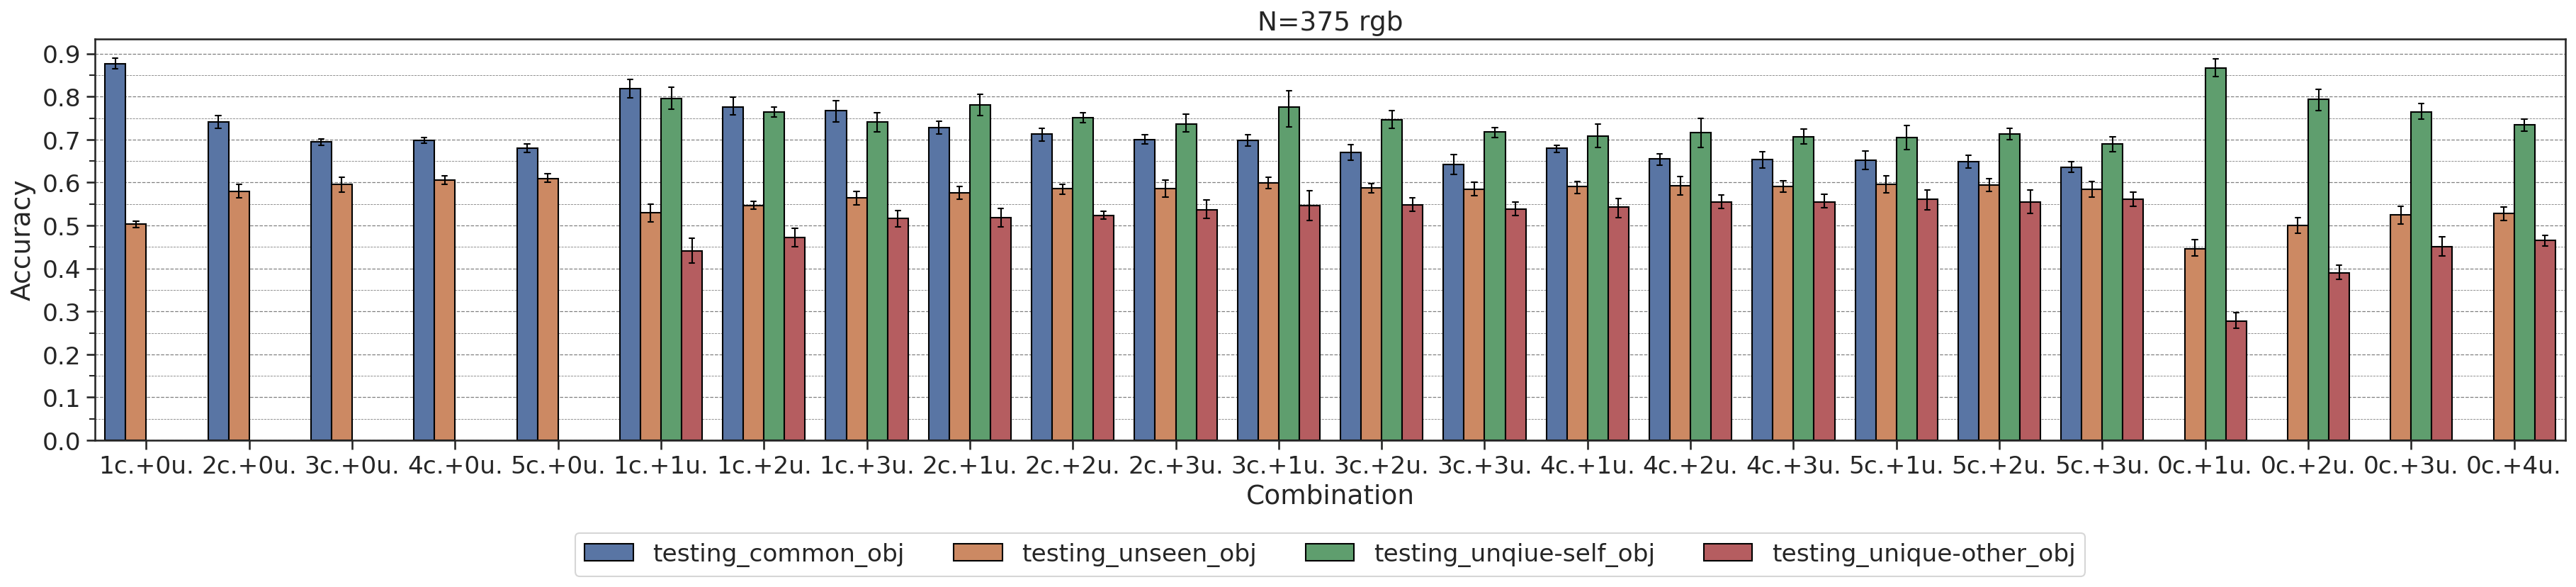

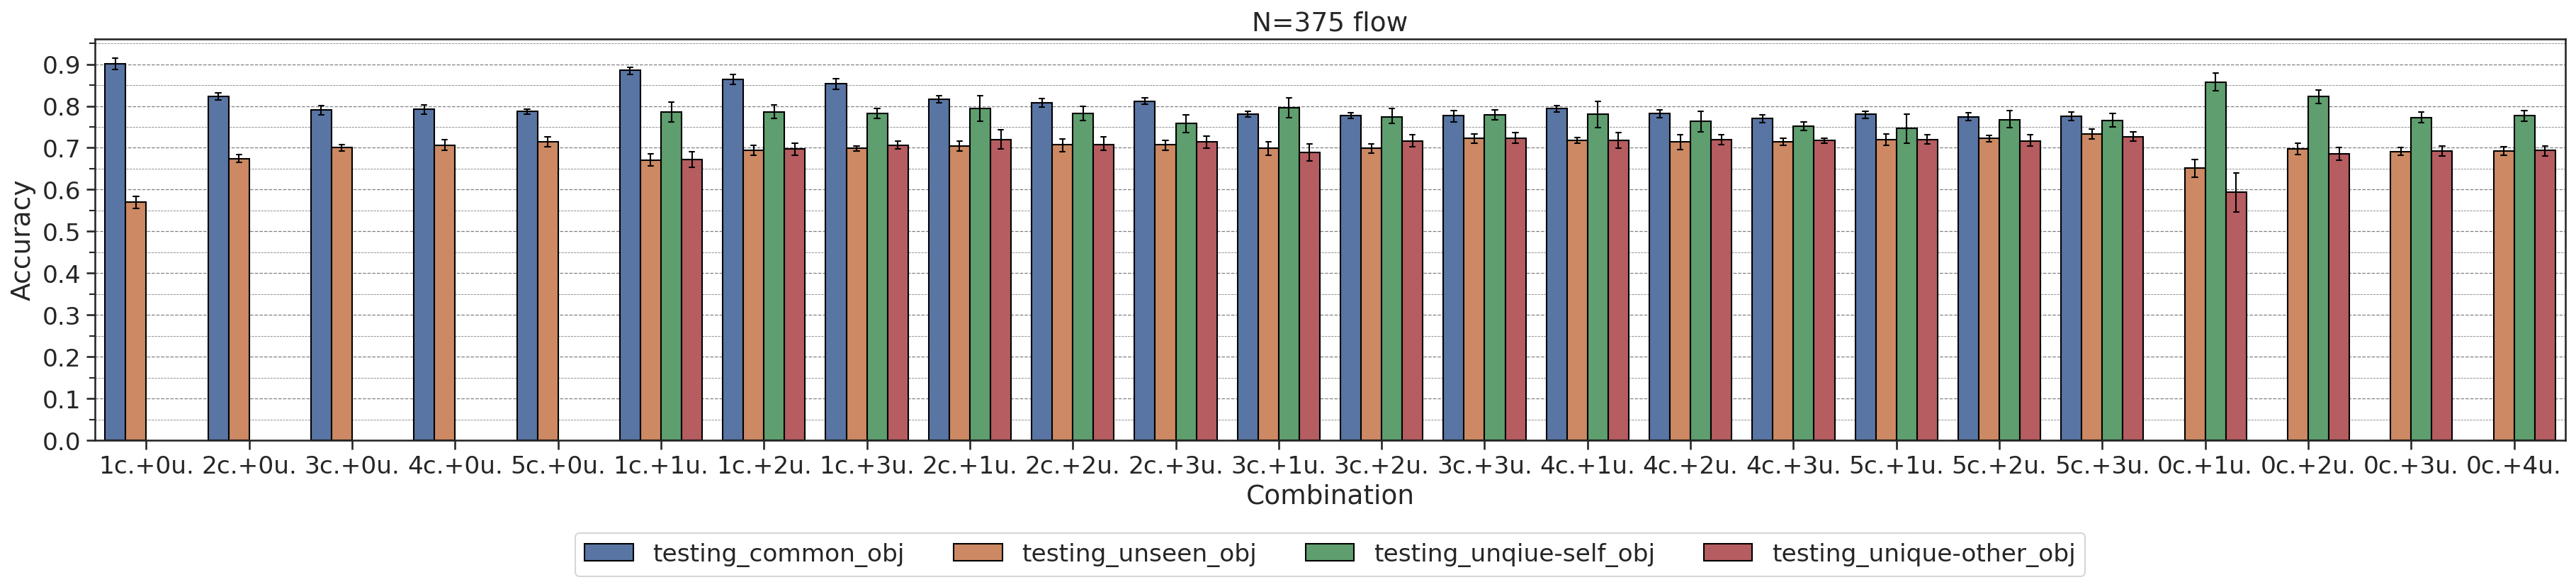

In [18]:
loss_balanced = 1
for input in ["rgb","flow"]:
    order = ['1c.+0u.', '2c.+0u.', '3c.+0u.', '4c.+0u.', '5c.+0u.', 
     '1c.+1u.', '1c.+2u.','1c.+3u.' ,
    '2c.+1u.','2c.+2u.', '2c.+3u.',
    '3c.+1u.', '3c.+2u.', '3c.+3u.',
     '4c.+1u.', '4c.+2u.','4c.+3u.',
     '5c.+1u.',  '5c.+2u.',  '5c.+3u.',
     '0c.+1u.','0c.+2u.','0c.+3u.','0c.+4u.']
    # order = None

    N = 375
    df_results_all_temp = df_results_all.query("input=='%s'"%input).query("loss_balanced==%d and N==%d"%(loss_balanced,N))


    df_temp = format_for_seaborn(df_results_all_temp,flatten=False)

    cmap = sns.color_palette(n_colors=6)
    plt.figure(dpi=150,figsize=(30,5))
    ax = sns.barplot(x="label",y="correctness",hue = "test_type",
                 data=df_temp,ci=95, hue_order = test_name_map.keys(),edgecolor='black',capsize=0.05,errcolor="black", errwidth=1,
                palette = cmap,order=order)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.grid(which='major', linestyle='--', linewidth='0.6', color='black', alpha = 0.5)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth='0.4', color='black', alpha = 0.5)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=4)
    ax.set_xlabel("Combination")
    ax.set_ylabel("Accuracy")
    ax.set_title("N=%d %s"%(N,input))
    plt.xticks(rotation=0)
    #plt.savefig("../results/"+name+".pdf",dpi=200, bbox_inches='tight', pad_inches = 0)
    plt.show()
    plt.close()

In [28]:
df_results_all.sort_values(["train"])[["train","val","test"]]

,train,val,test
382,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-0_samplingseed-0.train.csv,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-0_samplingseed-0.val.csv,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-0_samplingseed-0.test.csv
343,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-1_samplingseed-1.train.csv,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-1_samplingseed-1.val.csv,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-1_samplingseed-1.test.csv
304,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-2_samplingseed-2.train.csv,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-2_samplingseed-2.val.csv,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-2_samplingseed-2.test.csv
265,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-3_samplingseed-3.train.csv,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-3_samplingseed-3.val.csv,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-3_samplingseed-3.test.csv
226,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-4_samplingseed-4.train.csv,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-4_samplingseed-4.val.csv,../data/something/cvpr-v4/exp_N-125_NumCommonNouns-1_NumUniqueNouns-0_seed-4_samplingseed-4.test.csv
...,...,...,...
161,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-5_samplingseed-5.train.csv,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-5_samplingseed-5.val.csv,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-5_samplingseed-5.test.csv
122,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-6_samplingseed-6.train.csv,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-6_samplingseed-6.val.csv,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-6_samplingseed-6.test.csv
83,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-7_samplingseed-7.train.csv,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-7_samplingseed-7.val.csv,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-7_samplingseed-7.test.csv
44,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-8_samplingseed-8.train.csv,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-8_samplingseed-8.val.csv,../data/something/cvpr-v4/exp_N-750_NumCommonNouns-5_NumUniqueNouns-0_seed-8_samplingseed-8.test.csv
